In [6]:
"""%load_ext autoreload
%autoreload 2
%load_ext wurlitzer"""

import sys
import json
from ruamel.yaml import YAML
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import lossmaps as lm

from scipy.constants import c as clight

from cpymad.madx import Madx

import xpart as xp
import xtrack as xt
import xobjects as xo
import xdyna as xd
import xcoll as xc
# import xboinc as xb

# context = xo.ContextCpu(omp_num_threads=26)
context = xo.ContextCpu()

No pytransport functionality
No pytransport functionality


In [7]:
coll = xc.EverestCrystal(length=0.004, material=xc.materials.SiliconCrystal, 
                         bending_radius = 80.00,  xdim = 2.0e-3,  ydim = 35.0e-3,  side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
                         align_angle=0.0, _context=context)

# coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bend=0.002/149e-6,
#                          xdim=0.002, ydim=0.05, side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
#                          align_angle=0.0, _context=context)

# coll = xc.EverestCollimator(length=0.004, material=xc.materials.Silicon, side='+', jaw_L=0.001, jaw_R=-0.001,
#                          _context=context)

num_part = int(1e6)
x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
px_init  = np.random.uniform(low=-50.e-6, high=250.e-6, size=num_part)
y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)
part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=6.8e12, _context=context)
# part._init_random_number_generator()
part_init = part.copy()

io_buffer = xt.new_io_buffer(capacity=int(2e7)) # 4-5 GB of memory
impacts = xt.start_internal_logging(elements=[coll], io_buffer=io_buffer, capacity=io_buffer.capacity)

Compiling ContextCpu kernels...


634b62ac5e244d3b9193d2072ec44e64.c: In function 'scatter_cry':
634b62ac5e244d3b9193d2072ec44e64.c:9926:28: warning: unused variable 'x_P' [-Wunused-variable]
 9926 |                     double x_P = -s_P_tmp*sin(tilt_int) + x_P_tmp*cos(tilt_int);
      |                            ^~~
634b62ac5e244d3b9193d2072ec44e64.c:9925:28: warning: unused variable 's_P' [-Wunused-variable]
 9925 |                     double s_P = s_P_tmp*cos(tilt_int) + x_P_tmp*sin(tilt_int);
      |                            ^~~
634b62ac5e244d3b9193d2072ec44e64.c:9823:18: warning: unused variable 'cry_spTilt' [-Wunused-variable]
 9823 |     double const cry_spTilt = sin(cry_tilt);
      |                  ^~~~~~~~~~
634b62ac5e244d3b9193d2072ec44e64.c:9813:12: warning: unused variable 'offset' [-Wunused-variable]
 9813 |     double offset   = everest->coll->offset;
      |            ^~~~~~


Done compiling ContextCpu kernels.


In [8]:
coll.critical_angle

In [9]:
%time coll.track(part)

# Sort particles again
part.sort(interleave_lost_particles=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
CPU times: user 459 ms, sys: 219 ms, total: 677 ms
Wall time: 2.84 s


In [10]:
coll.critical_angle

2.0263017628986463e-06

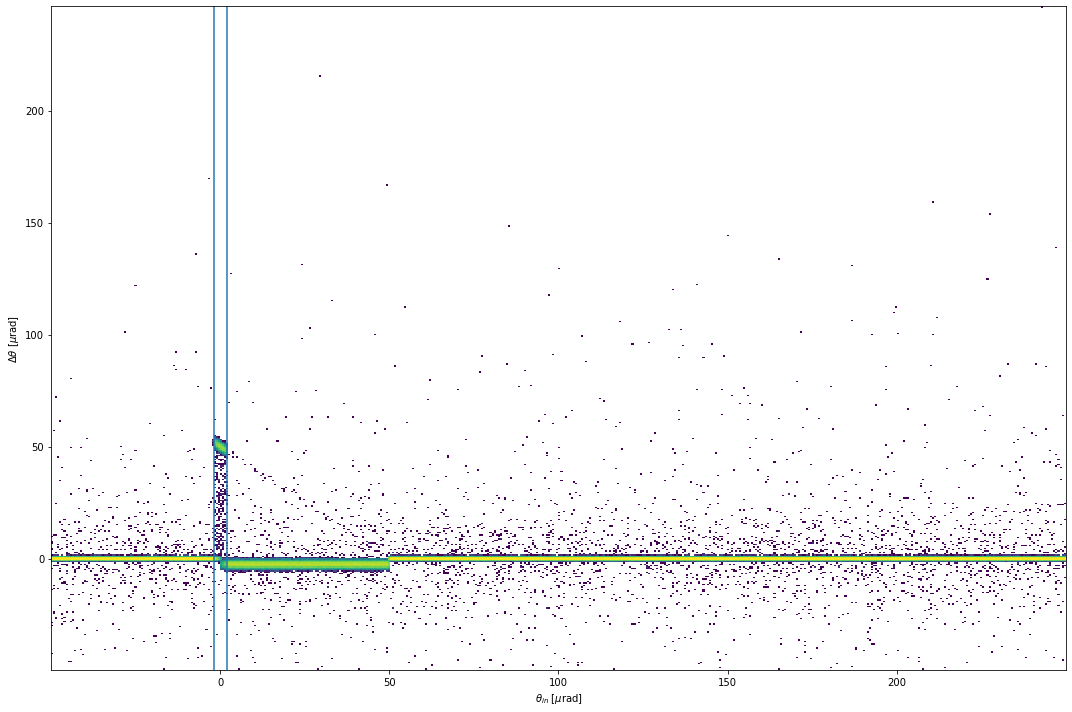

In [22]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(15,10))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

# smear_x = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
# smear_y = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]*1.e6+smear_x, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 + smear_y, 500, norm=mpl.colors.LogNorm())
plt.axvline(coll.critical_angle*1e6, ymin=0, ymax=1)
plt.axvline(-coll.critical_angle*1e6, ymin=0, ymax=1)
#plt.xlim(-10, 10)
#plt.ylim(-55, 100)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

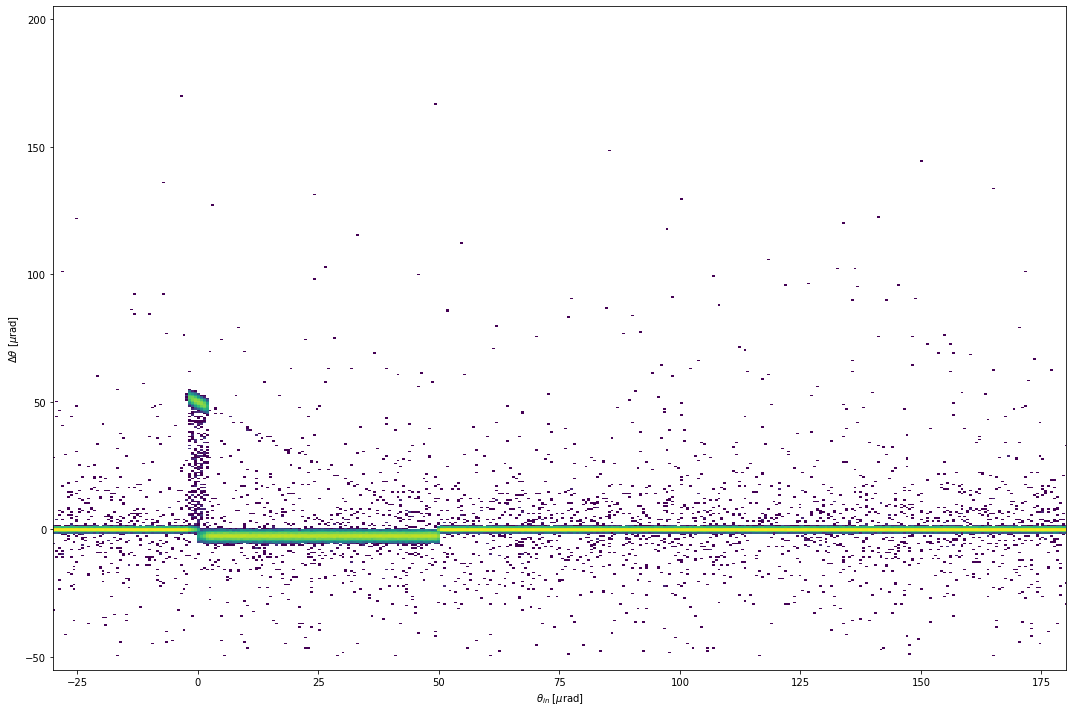

In [12]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(15,10))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

# smear_x = np.random.normal(loc=0., scale=5., size=len(part_init.px[mask]))
# smear_y = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]*1.e6+smear_x, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 + smear_y, 500, norm=mpl.colors.LogNorm())
plt.xlim(-30, 180)
plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

In [15]:
df_imp.columns



Index(['turn', 'collimator id', 'interaction_type', 'ds', 'parent_id',
       'parent_x', 'parent_px', 'parent_y', 'parent_py', 'parent_zeta',
       'parent_delta', 'parent_energy', 'parent_mass', 'parent_charge',
       'parent_z', 'parent_a', 'parent_pdgid', 'child_id', 'child_x',
       'child_px', 'child_y', 'child_py', 'child_zeta', 'child_delta',
       'child_energy', 'child_mass', 'child_charge', 'child_z', 'child_a',
       'child_pdgid'],
      dtype='object')

In [14]:
df_imp = impacts.to_pandas()
len(part.state[part.state<0])

8569

In [117]:
df_imp[df_imp.parent_id == 100].iloc[-1][['parent_id', 'interaction_type', 'parent_x', 'parent_y', 'parent_px', 'parent_py', 'child_x', 'child_y', 'child_px', 'child_py']]

parent_id                100
interaction_type    Exit Jaw
parent_x            0.000664
parent_y           -0.000715
parent_px           0.000209
parent_py                0.0
child_x                 -1.0
child_y                 -1.0
child_px                -1.0
child_py                -1.0
Name: 342, dtype: object

In [ ]:
TCCS
CrystalAnalysis(n_sigma=99.9, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-0.00019467652350207016, sigma=0.0002779120089875385, jaw_L=0.02870808412824294)
TARGET
TargetAnalysis(n_sigma=99.9, length=0.005, ydim=0.002, xdim=0.008,sigma=0.0003042139434683834, jaw_L=0.03094190481621916)
TCCP
CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=1.6492758564060823e-05, sigma=0.0003042304361317982, jaw_L=0.0020720980986829963)
TCP
TargetAnalysis(n_sigma=6.700000000000001, length=0.6, ydim=0.025, xdim=0.025,sigma=0.00034306467332267693, jaw_L=0.0021412841164830314)
TCLA
TargetAnalysis(n_sigma=23.7, length=1.0, ydim=0.025, xdim=0.025,sigma=0.00024210413297067086,  jaw_L=0.005976474818295799)
PIXEL
TargetAnalysis(n_sigma=21.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.00030776207540242356)

In [2]:
0.0020720980986829963 - 0.0020720980986830284

-3.209238430557093e-17

In [ ]:
TCCS
CrystalAnalysis(n_sigma=103.29918535305274, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-0.00019467652350207016, sigma=0.0002779120089875385, jaw_L=0.028708084128242994)
TARGET
TargetAnalysis(n_sigma=101.71100135465989, length=0.005, ydim=0.002, xdim=0.008,sigma=0.0003042139434683834, jaw_L=0.030941904816219168)
TCCP
CrystalAnalysis(n_sigma=6.810949374523979, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=1.6492758564060823e-05, sigma=0.0003042304361317982, jaw_L=0.0020720980986830284)
TCP
TargetAnalysis(n_sigma=6.241633962903068, length=0.6, ydim=0.025, xdim=0.025,sigma=0.00034306467332267693, jaw_L=0.0021412841164830665)
TCLA
TargetAnalysis(n_sigma=24.68555470310695, length=1.0, ydim=0.025, xdim=0.025,sigma=0.00024210413297067086,  jaw_L=0.005976474818295774)
PIXEL
TargetAnalysis(n_sigma=21.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.00030776207540242356)

In [ ]:
COs  = np.cos(np.float_(90)*np.pi/180) * x
COs += np.sin(np.float_(90)*np.pi/180) * y

In [3]:
 np.cos(np.float_(90)*np.pi/180) 

NameError: name 'np' is not defined

In [4]:
df3.columns


NameError: name 'df3' is not defined

In [140]:
len( df_imp[df_imp.interaction_type == 'Rutherford'])

6

In [136]:
df4.parent_x 

0          0.000554
3          0.000452
8          0.000475
11         0.000507
14         0.000604
             ...   
3333783    0.000625
3333786    0.000436
3333789    0.000487
3333792    0.000451
3333797    0.000510
Name: parent_x, Length: 1000000, dtype: float64

In [134]:
df5.parent_x 

2          0.000555
7          0.000452
10         0.000476
13         0.000507
18         0.000604
             ...   
3333785    0.000625
3333788    0.000436
3333791    0.000488
3333796    0.000451
3333801    0.000511
Name: parent_x, Length: 991491, dtype: float64

In [143]:
df4.parent_x + coll.jaw_L == x_init

0          True
3          True
8          True
11         True
14         True
           ... 
3333783    True
3333786    True
3333789    True
3333792    True
3333797    True
Name: parent_x, Length: 1000000, dtype: bool

: 

In [ ]:
df_imp.


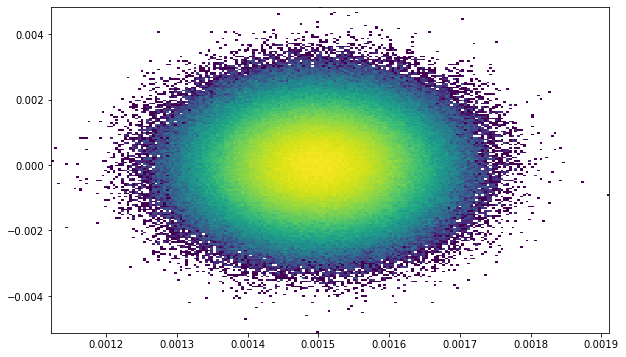

In [142]:
df4 = df_imp[df_imp.interaction_type == 'Enter Jaw']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df4.parent_x + coll.jaw_L, df4.parent_y, 200, norm=mpl.colors.LogNorm())
#plt.ylim(-20.e-6, 10.e-6)

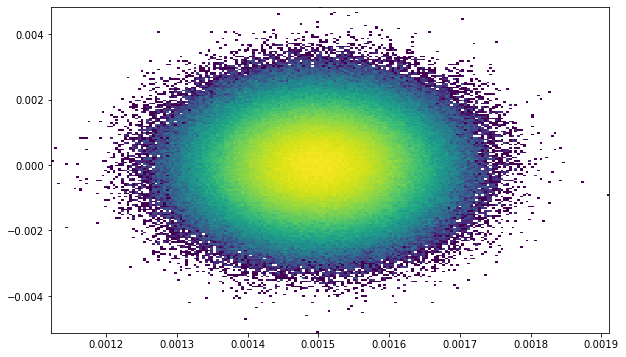

In [129]:
plt.figure(figsize=(10,6))
_ = plt.hist2d(x_init, y_init, 200, norm=mpl.colors.LogNorm())

(-2e-05, 1e-05)

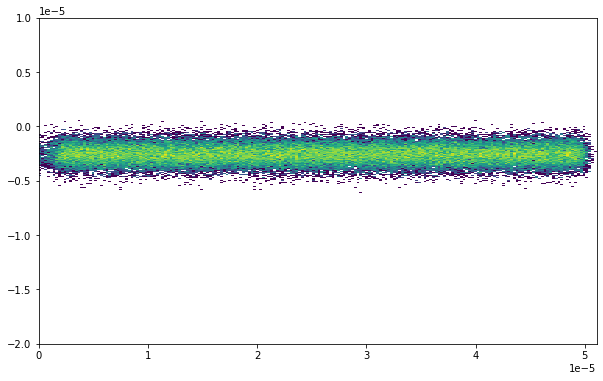

In [121]:
df3 = df_imp[df_imp.interaction_type == 'Volume Reflection']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df3.parent_px, df3.child_px - df3.parent_px, 200, norm=mpl.colors.LogNorm())
plt.ylim(-20.e-6, 10.e-6)

(-0.0015, 0.0015)

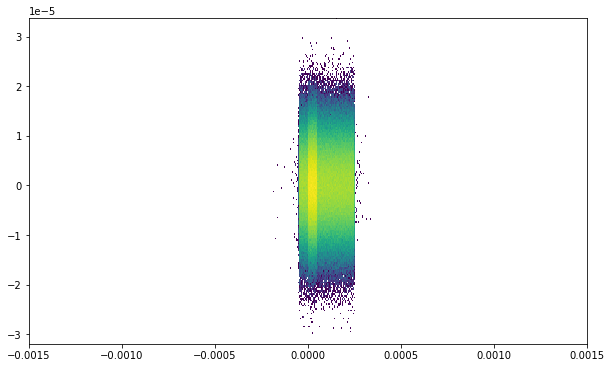

In [122]:
df3 = df_imp[df_imp.interaction_type == 'Multiple Coulomb Scattering']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df3.parent_px, (df3.child_px - df3.parent_px) / np.sqrt(df3.ds), 200, norm=mpl.colors.LogNorm())
plt.xlim(-1.5e-3, 1.5e-3)
# plt.ylim(-30.e-6, 30.e-6)

In [25]:
df = impacts.interactions_per_collimator()
# df.loc[576926] = []
result = [inters for inters in df if inters[-1] == 'CH']
print(len(result))
result

43464


[['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['

In [33]:
df

pid
0         [MCS, VR, MCS]
1         [MCS, VR, MCS]
2         [MCS, VR, MCS]
3                  [MCS]
4         [MCS, VR, MCS]
               ...      
999995    [MCS, VR, MCS]
999996             [MCS]
999997    [MCS, VR, MCS]
999998    [MCS, VR, MCS]
999999             [MCS]
Name: int, Length: 1000000, dtype: object

In [26]:
result = np.unique(df.values, return_counts=True)
print(result[1].sum())
for inter, n in zip(result[0], result[1]):
    print(inter, n)

1000000
['CH'] 42294
['CH', 'A'] 42
['CH', 'DCH', 'MCS'] 2332
['CH', 'DCH', 'MCS', 'A'] 7
['CH', 'DCH', 'MCS', 'PN', 'MCS'] 2
['CH', 'DCH', 'MCS', 'PN', 'MCS', 'VR', 'MCS'] 1
['CH', 'DCH', 'MCS', 'SD', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VC', 'CH'] 4
['CH', 'DCH', 'MCS', 'VC', 'CH', 'DCH', 'MCS', 'VR', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VC', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 2252
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A'] 7
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'PN', 'MCS', 'VR', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'PP', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'RU', 'MCS', 'VR', 'MCS'] 1
['CH', 'PN', 'MCS'] 14
['CH', 'PN', 'MCS', 'VR', 'MCS'] 3
['CH', 'PP', 'MCS'] 4
['CH', 'SD', 'MCS'] 3
['CH', 'SD', 'MCS', 'VR', 'MCS'] 1
['MCS'] 476096
['MCS', 'A'] 3017
['MCS', 'PN', 'MCS'] 1008
['MCS', 'PN', 'MCS', 'A'] 5
['MCS', 'PN', 'MCS', 'PN', 'MCS'] 1
['MCS', 'PN', 'MCS', 'VR', 'MCS'] 208
['MCS', 'PP', 'MCS'] 246
['MCS', 'PP', 'MCS', 'PN', 'MCS'] 1
['MCS', 'PP', 'MCS', 'VC', 'CH'] 1
['MCS', '

In [19]:
mask1 = ['PP' in proc or 'PN' in proc or 'SD' in proc or 'RU' in proc or 'A' in proc for proc in df.sort_index().values]
mask1 = [proc != ['DRVI', 'VR', 'VRAM', 'MCS'] for proc in df.sort_index().values]
mask2 = ['AMVR' in proc for proc in df.sort_index().values]

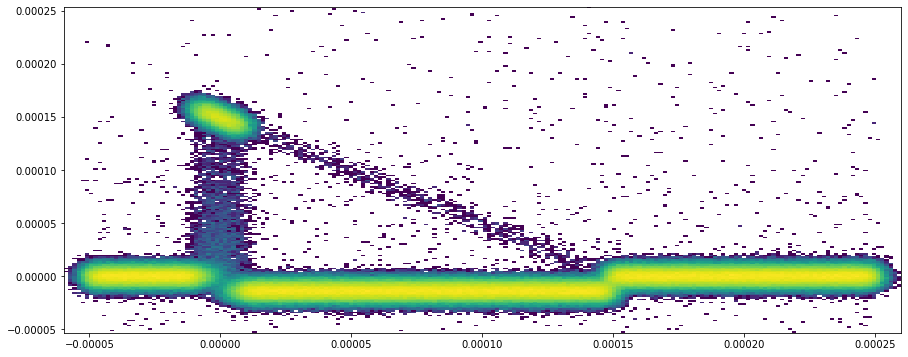

In [39]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2

plt.figure(figsize=(15,6))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

smear_x = np.random.normal(loc=0., scale=2.8e-6, size=len(part_init.px[mask]))
smear_y = np.random.normal(loc=0., scale=2.8e-6, size=len(part_init.px[mask]))
#smear_x = 0
#smear_y = 0
_ = plt.hist2d(part_init.px[mask]+smear_x, part.px[mask] - part_init.px[mask] + smear_y, 200, norm=mpl.colors.LogNorm())
# plt.ylim(-50.e-6, 50.e-6)
# plt.xlim(130.e-6, 170.e-6)
# plt.ylim(-50.e-6, 20.e-6)

In [81]:
short_inter = []
for inter in result[0]:
    short_inter += [ inter[:2] ]
np.unique(short_inter)

/home/fvanderv/miniconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


array([list(['CH']), list(['CH', 'A']), list(['CH', 'DCH']),
       list(['CH', 'PN']), list(['CH', 'PP']), list(['CH', 'RU']),
       list(['CH', 'SD']), list(['MCS']), list(['MCS', 'A']),
       list(['MCS', 'PN']), list(['MCS', 'PP']), list(['MCS', 'RU']),
       list(['MCS', 'SD']), list(['VRAM', 'MCS']), list(['VRCH', 'MCS'])],
      dtype=object)

In [17]:
Nc = 0
Nd = 0
Nca = 0
Ncn = 0
for inter, n in zip(result[0], result[1]):
    if inter[0] == 'CH':
        Nc += n
        if len(inter) >1:
            if inter[1] == 'DCH':
                Nd += n
            elif inter[1] == 'A':
                Nca += n
            elif inter[1] == 'PN' or inter[1] == 'PP' or inter[1] == 'RU' or inter[1] == 'SD':
                Ncn += n
print(f"Nc: {Nc/1e6:.1%}, of which:  Nca: {Nca/Nc:.1%},  Nd: {Nd/Nc:.1%},  Ncn: {Ncn/Nc:.1%}")

Nc: 0.0%, of which:  Nca: 0.0%,  Nd: 0.0%,  Ncn: 0.0%


1.4928213486648864e-07


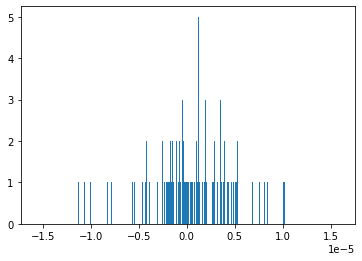

In [18]:
df2 = impacts.to_pandas()
df3 = df2[df2.interaction_type == 'Multiple Coulomb Scattering']
print(np.mean(df3['parent_px'] - df3['child_px']))

_ = plt.hist(df3['parent_px'] - df3['child_px'], 500)

In [19]:
df2 = impacts.to_pandas()
df2[df2['parent_id'] == 999996]

,turn,collimator id,interaction_type,ds,parent_id,parent_x,parent_px,parent_y,parent_py,parent_zeta,...,child_y,child_py,child_zeta,child_delta,child_energy,child_mass,child_charge,child_z,child_a,child_pdgid
